In [1]:
!pip install kaggle

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 kB 960.1 kB/s eta 0:00:000:0100:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.2/78.2 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.3/78.3 kB 4.6 MB/s eta 0:00:00
  Created wheel for kaggle: filename=kaggle-1.5.16-py3-none-any.whl size=110683 sha256=03fece51d1a528b5d3d6c2089f3d64b88e5fb3e9c9fdc400a52ec5f9e5c8efe5
  Stored in directory: /Users/ammaar/Library/Caches/pip/wheels/5a/ab/50/e224f599a07faf6d398a8600796012da271b7e5e7f2a3ab2b8
Successfully built kaggle


In [2]:
# Configuring the path of Kaggle.json file
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
# CIFAR-10 Dataset api
!kaggle competitions download -c cifar-10

cifar-10.zip: Skipping, found more recently modified local copy (use --force to force download)


In [6]:
# Extracting from the zip file
from zipfile import ZipFile
dataset = 'cifar-10.zip'

with ZipFile(dataset, 'r') as zip:
    zip.extractall()
    print('Extraction complete')

Extraction complete


In [7]:
!ls

Cifar10ObjectRecognition.ipynb test.7z
cifar-10.zip                   train.7z
kaggle.json                    trainLabels.csv
sampleSubmission.csv


We want the images in 'train.7z', we extract using py7zr

In [8]:
!pip install py7zr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 kB 1.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 446.2/446.2 kB 3.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 13.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 447.6/447.6 kB 30.1 MB/s eta 0:00:00
  Attempting uninstall: brotli
    Found existing installation: Brotli 1.0.9
    Uninstalling Brotli-1.0.9:
      Successfully uninstalled Brotli-1.0.9


In [9]:
import py7zr
archive = py7zr.SevenZipFile('train.7z', mode='r')
archive.extractall()
archive.close()

In [10]:
!ls

Cifar10ObjectRecognition.ipynb test.7z
cifar-10.zip                   train
kaggle.json                    train.7z
sampleSubmission.csv           trainLabels.csv


Now that the images are extracted, we can build a basic neural network

In [12]:
# Importing the dependencies
import os
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split

In [14]:
filenames = os.listdir('train')

Labels Processing

In [17]:
labels_df = pd.read_csv('trainLabels.csv')

In [20]:
# Checking if the data is sorted (id in ascending order), I am looking at the first 10 elements
labels_df.head(10)

,id,label
0,1,frog
1,2,truck
2,3,truck
3,4,deer
4,5,automobile
5,6,automobile
6,7,bird
7,8,horse
8,9,ship
9,10,cat


In [21]:
# Now, if the last 10 elements are in order
labels_df.tail(10)

,id,label
49990,49991,deer
49991,49992,bird
49992,49993,airplane
49993,49994,automobile
49994,49995,airplane
49995,49996,bird
49996,49997,frog
49997,49998,truck
49998,49999,automobile
49999,50000,automobile


In [22]:
# Checking if distribution is even to ensure model can make significant predictions
labels_df['label'].value_counts()

label
frog          5000
truck         5000
deer          5000
automobile    5000
bird          5000
horse         5000
ship          5000
cat           5000
dog           5000
airplane      5000
Name: count, dtype: int64

In [24]:
# Numerically encoding the labels
labels_dictionary = {'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}
labels = [labels_dictionary[i] for i in labels_df['label']]

In [25]:
# Double-checking if encoding was performed correctly
print(labels[0:5])
print(labels[-5:])

[6, 9, 9, 4, 1]
[2, 6, 9, 1, 1]


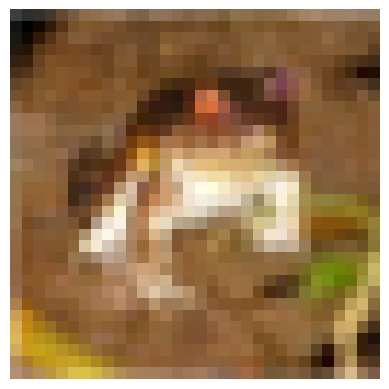

In [34]:
# Taking a look at a sample image
sample_image = Image.open('train/1.png') # Should be a frog
plt.imshow(sample_image)
plt.axis('off')  # Turn off axis numbers
plt.show()

In [ ]:
id_list = list(labels_df['id'])

Image Processing

In [ ]:
# conv